In [1]:
import argparse
import isce
import isceobj
import os
from osgeo import gdal
from osgeo import gdal_array
import numpy as np
import xml.etree.ElementTree as ET
import rasterio
from rasterio.plot import show
import glob
#import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [2]:
###Folowing files need to be the same size as your output grid.
latfile  = '/data/krd86/cropped/geom_reference/lat.rdr.4alks_20rlks.full.vrt'
lonfile  = '/data/krd86/cropped/geom_reference/lon.rdr.4alks_20rlks.full.vrt'

In [3]:
resampMethod = 'near'
cropdir      = '/data/krd86/cropped/cropscape/'
cropcropdir  = cropdir+'cropped/' 
os.mkdir(cropcropdir) # needs to exist and be empty
cropradardir = cropdir+'radar/'
os.mkdir(cropradardir) # needs to exist and be empty
infiles      = glob.glob(cropdir+'*CDL*tif')
infiles      = sorted(infiles)
infile       = infiles[0] # file for getting bounds, data type.  Assumes all others are on same grid
os.chdir(cropdir) # change to cropscape dir

In [4]:
###figure out bounds of lat/lonfile and crop input file
lf = gdal.Open(latfile)
stats = lf.GetRasterBand(1).GetStatistics(0,1)
sarMinLat = stats[0]
sarMaxLat = stats[1]
lf=None

###figure out bounds of lat/lonfile and crop input file
lf = gdal.Open(lonfile)
stats = lf.GetRasterBand(1).GetStatistics(0,1)
sarMinLon = stats[0]
sarMaxLon = stats[1]
lf=None

###get pixel spacing on infile
lf    = gdal.Open(infile)
stats = lf.GetGeoTransform()
dLon  = stats[1]
dLat  = -stats[5]
band = lf.GetRasterBand(1)
arr = band.ReadAsArray()
dtype = gdal.GetDataTypeName(band.DataType)
print(dtype)
#plt.imshow(arr)
#plt.show()
lf   = None


Byte


In [5]:
###Crop file to one pixel wider than extent of radar coordinates data
for file in infiles:
    cropfile = cropcropdir+os.path.basename(file)
    cmd = 'gdalwarp -te '+str(sarMinLon-dLon)+' '+str(sarMinLat-dLat)+' '+str(sarMaxLon+dLon)+' '+str(sarMaxLat+dLat)+' '+file+' '+cropfile
    os.system(cmd)
    ###build a vrt file for our tiff
    cmd='gdalbuildvrt '+cropfile+'.vrt '+cropfile
    os.system(cmd)

Copying color table from /data/krd86/cropped/cropscape/CDL_2008_clip_20220408094633_39327711.tif to new file.
Creating output file that is 3898P x 1835L.
Processing /data/krd86/cropped/cropscape/CDL_2008_clip_20220408094633_39327711.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Copying color table from /data/krd86/cropped/cropscape/CDL_2009_clip_20220408094633_39327711.tif to new file.
Creating output file that is 3898P x 1835L.
Processing /data/krd86/cropped/cropscape/CDL_2009_clip_20220408094633_39327711.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Copying color table from /data/krd86/cropped/cropscape/CDL_2010_clip_20220408094633_39327711.tif to new file.
Creating output file that is 3898P x 1835L.
Processing /data/krd86/cropped/cropscape/CDL_2010_clip_20220408094633_39327711.tif [1/1] : 0...10...20...30...40

2022-04-21 15:37:45,000 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7f66cbde4670>
2022-04-21 15:37:45,004 - rasterio.env - DEBUG - Starting outermost env
2022-04-21 15:37:45,005 - rasterio.env - DEBUG - No GDAL environment exists
2022-04-21 15:37:45,013 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7f66cbd25880> created
2022-04-21 15:37:45,015 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2022-04-21 15:37:45,016 - rasterio._env - DEBUG - PROJ_LIB found in environment.
2022-04-21 15:37:45,017 - rasterio._env - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x7f66cbd25880>.
2022-04-21 15:37:45,019 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7f66cbde4670>
2022-04-21 15:37:45,020 - rasterio._base - DEBUG - Sharing flag: 0
2022-04-21 15:37:45,034 - rasterio._base - DEBUG - Nodata success: 0, Nodata value: -10000000000.000000
2022-04-21 15:37:45,035 - rasterio._base

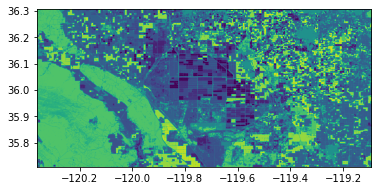

<AxesSubplot:>

In [15]:
img=rasterio.open(cropfile,'r')
show(img)

In [6]:
def writeVRT(infile, latFile, lonFile):
#This function is modified from isce2gis.py
            tree = ET.parse(infile + '.vrt')
            root = tree.getroot()

            meta = ET.SubElement(root, 'metadata')
            meta.attrib['domain'] = "GEOLOCATION"
            meta.tail = '\n'
            meta.text = '\n    '


            rdict = { 'Y_DATASET' : latFile,
                      'X_DATASET' : lonFile,
                      'X_BAND' : "1",
                      'Y_BAND' : "1",
                      'PIXEL_OFFSET': "0",
                      'LINE_OFFSET' : "0",
                      'LINE_STEP' : "1",
                      'PIXEL_STEP' : "1" }

            for key, val in rdict.items():
                data = ET.SubElement(meta, 'mdi')
                data.text = val
                data.attrib['key'] = key
                data.tail = '\n    '

            data.tail = '\n'
            tree.write(infile + '.vrt')

In [7]:
##get number of rows and columns in radar coords file (lat)
raster = gdal.Open(latfile)
radarnx=raster.RasterXSize
radarny=raster.RasterYSize
cols,rows=np.meshgrid(np.arange(1,radarnx+1),np.arange(radarny,0,-1))

#make new files of columns and rows, in radar coordinates
colfile = 'cols.r4'
rowfile = 'rows.r4'
gcolfile = 'geo_colscropscape.r4'
growfile = 'geo_rowscropscape.r4'
driver=gdal.GetDriverByName('ISCE')
colds = driver.Create(colfile,radarnx,radarny,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(cols)
colds=None

colds = driver.Create(rowfile,radarnx,radarny,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(rows)
colds=None

cmd = 'fixImageXml.py -i '+colfile+' -f'
os.system(cmd)
cmd = 'fixImageXml.py -i '+rowfile+' -f'
os.system(cmd)
writeVRT(colfile, latfile, lonfile)
writeVRT(rowfile, latfile, lonfile)

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [8]:
##get number of rows and columns + min/max range of input file
cropfile = cropcropdir+os.path.basename(infile)
raster = gdal.Open(cropfile)
geonx=raster.RasterXSize
geony=raster.RasterYSize

minLon = raster.GetGeoTransform()[0]
deltaLon = raster.GetGeoTransform()[1]
maxLat = raster.GetGeoTransform()[3]
deltaLat = raster.GetGeoTransform()[5]
minLat = maxLat + geony*deltaLat
maxLon = minLon + geonx*deltaLon
WSEN = str(minLon)+' '+str(minLat)+' '+str(maxLon)+' '+str(maxLat)


In [9]:
#geocode row and col file
cmd = 'gdalwarp -of ISCE -geoloc  -te '+WSEN+' -tr '+str(deltaLon)+' '+str(deltaLat)+' -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear ' +rowfile +'.vrt ' + growfile
print(cmd)
os.system(cmd)
cmd = 'gdalwarp -of ISCE -geoloc  -te '+WSEN+' -tr '+str(deltaLon)+' '+str(deltaLat)+' -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear ' +colfile +'.vrt ' + gcolfile
print(cmd)
os.system(cmd)
cmd = 'gdalbuildvrt '+gcolfile+'.vrt '+gcolfile
os.system(cmd)
cmd = 'gdalbuildvrt '+growfile+'.vrt '+growfile
os.system(cmd)

gdalwarp -of ISCE -geoloc  -te -120.36265964338409 35.709013610223195 -119.09242587876591 36.3071146704308 -tr 0.0003258680771211347 -0.00032594063226572425 -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear rows.r4.vrt geo_rowscropscape.r4
Creating output file that is 3898P x 1835L.
Processing rows.r4.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp -of ISCE -geoloc  -te -120.36265964338409 35.709013610223195 -119.09242587876591 36.3071146704308 -tr 0.0003258680771211347 -0.00032594063226572425 -srcnodata 0 -dstnodata 0  -wt float32 -r bilinear cols.r4.vrt geo_colscropscape.r4
Creating output file that is 3898P x 1835L.
Processing cols.r4.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [10]:
###set any geocoding info
WSEN = '0.5 0.5 '+str(radarnx+0.5)+' '+str(radarny+0.5)
for file in infiles:
    cropfile = cropcropdir+os.path.basename(file)
    outfile  = cropradardir+os.path.basename(file)
    writeVRT(cropfile, growfile, gcolfile)
    cmd = 'gdalwarp -geoloc -of ISCE -te '+ WSEN + ' -tr 1 1 -srcnodata 0 -dstnodata 0 -wt '+dtype+' -r ' + resampMethod + ' ' + cropfile +'.vrt ' +outfile
    os.system(cmd)
    cmd = 'gdalbuildvrt '+outfile+'.vrt '+outfile
    os.system(cmd)

Copying color table from /data/krd86/cropped/cropscape/cropped/CDL_2008_clip_20220408094633_39327711.tif.vrt to new file.
Creating output file that is 1500P x 875L.
Processing /data/krd86/cropped/cropscape/cropped/CDL_2008_clip_20220408094633_39327711.tif.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Copying color table from /data/krd86/cropped/cropscape/cropped/CDL_2009_clip_20220408094633_39327711.tif.vrt to new file.
Creating output file that is 1500P x 875L.
Processing /data/krd86/cropped/cropscape/cropped/CDL_2009_clip_20220408094633_39327711.tif.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Copying color table from /data/krd86/cropped/cropscape/cropped/CDL_2010_clip_20220408094633_39327711.tif.vrt to new file.
Creating output file that is 1500P x 875L.
Processing /data/krd86/cropped/cropscape/cropped/CDL_20